In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
%matplotlib inline
import scipy.spatial as ss
import pickle
import os
import numpy as np
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, RationalQuadratic, Matern
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.model_selection import learning_curve

In [2]:
data_loc = "../Data"
phys_cache = "proc_physical_3sig.pkl"
plot_loc = "../Plots"
n_neighbors = 200

In [3]:
# Load physical data
if os.path.exists(os.path.join(data_loc,phys_cache)):
    print("Reading data from cache:",phys_cache)
    with open(os.path.join(data_loc,phys_cache), 'rb') as handle:
        X, y, names = pickle.load(handle)
else:
    raise NameError("%s not defined." % phys_cache)

Reading data from cache: proc_physical_3sig.pkl


## Use a KD-Tree and Run Gaussian Processes on batches of the Data

After the GP has been run on a batch, remove the batch and run GP on another part of the data. The problem seems to be we dont touch every point.

In [4]:
def kd_training(X, y, est, n_neighbors=200):
    """
    Docs TODO
    
    Parameters
    ----------
    X : array (n_samples x n_features)
        data
    y : array (n_samples)
        target variable
    n_neighbors : int (optional)
        Number of nearest neighbors for training.  Defaults to 200
    
    Returns
    -------
    inds : list
        indicies of samples in X not used for 
    
    """
    
    # Build the kd tree for NN searching
    tree = ss.KDTree(X)
    
    # Make list of sample indicies to prevent repeating
    # inds = [x for x in range(X.shape[0])]
    inds = list(np.arange(X_train.shape[0]))
    
    # Number of fitting batches
    n_batches = int(X.shape[0]/n_neighbors)
    n_batches = X.shape[0]
    
    # make arrays to store params
    noise = np.zeros(n_batches)
    length_scale = np.zeros_like(noise)
    
    # store std
    std_list = []
    
    # Loop over fitting batches
    for ii in range(n_batches):
        # Draw random sample for fitting
        # center = random.choice(inds)
        center = ii
        
        # Find nearest neighbors for fitting
        fit_dist, fit_inds = tree.query(X[center],k=n_neighbors)
        # print(fit_inds)
        
        est.fit(X[fit_inds],y[fit_inds])
        
        # store kernel params here
        noise[ii] = est.kernel_.k1.get_params()['noise_level']
        length_scale[ii] = est.kernel_.k2.get_params()['length_scale']
        
        # store y_std
        y_pred, y_std = est.predict(X[fit_inds], return_std=True)
        std_list.append(y_std)
        
        # Remove previous samples from center consideration
        for ind in fit_inds:
            if ind in inds:
                inds.remove(ind)
                pass
                    
    return std_list, noise, length_scale, fit_dist
# end function

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Scale data to 0 mean, 1 std
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Matern gives 
kernel = WhiteKernel() + Matern()

# add n_restarts_optimizer
est = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, random_state=42)

In [10]:
std_list, noise, length_scale, fit_dist = kd_training(X_train, y_train, est, n_neighbors=200)

/Users/mwilde/anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  5.40773520e-04,   1.21169048e-05]), 'nit': 7, 'funcalls': 50}
  " state: %s" % convergence_dict)


(array([  2.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   1.20000000e+01,   9.00000000e+01,
          5.72000000e+02,   3.35900000e+03,   3.65000000e+03,
          3.02000000e+02]),
 array([ 0.00447193,  0.04181086,  0.07914979,  0.11648873,  0.15382766,
         0.1911666 ,  0.22850553,  0.26584446,  0.3031834 ,  0.34052233,
         0.37786127]),
 <a list of 10 Patch objects>)

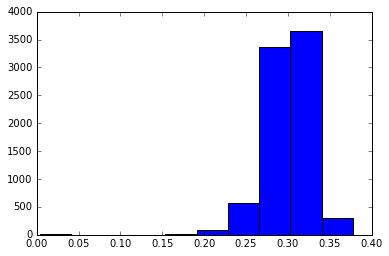

In [11]:
plt.hist(np.median(std_list, axis=1), 10)

(array([  2.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   1.20000000e+01,   9.40000000e+01,
          5.69000000e+02,   3.37600000e+03,   3.63400000e+03,
          3.00000000e+02]),
 array([ 0.00447191,  0.04187583,  0.07927976,  0.11668368,  0.1540876 ,
         0.19149152,  0.22889544,  0.26629936,  0.30370329,  0.34110721,
         0.37851113]),
 <a list of 10 Patch objects>)

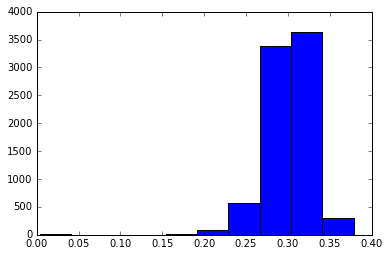

In [14]:
plt.hist(np.mean(std_list, axis=1))

In [15]:
len(X_train)

7993

In [16]:
len(std)

NameError: name 'std' is not defined